# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [3]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.65, 0.25], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.65, 0.25], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.55, 0.45], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process


# choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                  "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}
# preprocess_text = TextAugment([0.05, 0.2, 0.2, 0.3, 0.25], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

# choice_probas_test = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.0, "char_delete": 0.2,
#                  "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
#                  "stopword_insert": 0.3, "word_join": 0.2, "word_cutout": 0.8,
#                  "text_rotate": 0.0, "sentence_shuffle": 0.0, 
#                       "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.5}

# preprocess_text_test = TextAugment([0.1, 0.9], choice_probas_test, fasttext_file="wiki-news-300d-1M-subword.bin")

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


In [4]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

In [5]:


scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# Params

In [ ]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




# BERT Models

## Non Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.851	0.666


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs




## Head Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.05,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval Head Ensemble


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 20
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs

# 0.799	0.657 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.1,
# 0.780	0.634 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.15, 
# 0.806	0.648 gaussian_noise=0.0, dropout=0.02, word_masking_proba=0.1
# 0.803	0.655 gaussian_noise=0.0, dropout=0.1, word_masking_proba=0.1, (0.807	0.657) 0.803	0.653


## Decoder Ensemble

### Train All Params

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.718772 LR = 0.00000348



Epoch =  2 Loss = 0.550060 LR = 0.00000697



Epoch =  3 Loss = 0.498758 LR = 0.00001045



Epoch =  4 Loss = 0.483025 LR = 0.00001393



Epoch =  5 Loss = 0.474293 LR = 0.00001742



Epoch =  6 Loss = 0.468750 LR = 0.00002090



Epoch =  7 Loss = 0.464112 LR = 0.00002439



Epoch =  8 Loss = 0.445096 LR = 0.00002787



Epoch =  9 Loss = 0.433669 LR = 0.00003135



Epoch =  10 Loss = 0.427765 LR = 0.00003484



Epoch =  11 Loss = 0.410222 LR = 0.00003832



Epoch =  12 Loss = 0.407620 LR = 0.00004180



Epoch =  13 Loss = 0.395988 LR = 0.00004529



Epoch =  14 Loss = 0.392119 LR = 0.00004877



Epoch =  15 Loss = 0.388016 LR = 0.00004995



Epoch =  16 Loss = 0.378539 LR = 0.00004970



Epoch =  17 Loss = 0.380119 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.257 0.767     0   1
1      0.350 0.791     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.461,"[0.5391131639480591, 0.46088677644729614]",0,0,0.362,"[0.6375855803489685, 0.3624144196510315]",0,0,0.485,"[0.5150215029716492, 0.48497849702835083]",0,0
1,0.502,"[0.49781566858291626, 0.5021843314170837]",1,1,0.473,"[0.5270142555236816, 0.47298574447631836]",0,1,0.731,"[0.26916807889938354, 0.7308319211006165]",1,0
2,0.667,"[0.33346617221832275, 0.6665338277816772]",1,0,0.685,"[0.3153882324695587, 0.6846117377281189]",1,1,0.484,"[0.5161066055297852, 0.48389342427253723]",0,1
3,0.606,"[0.3939986824989319, 0.6060013175010681]",1,0,0.565,"[0.43538790941238403, 0.5646121501922607]",1,1,0.491,"[0.5088193416595459, 0.4911806881427765]",0,1
4,0.690,"[0.3097067177295685, 0.6902932524681091]",1,1,0.411,"[0.5887421369552612, 0.41125786304473877]",0,0,0.530,"[0.47012901306152344, 0.5298709869384766]",1,1


scores =  {'map': '0.6070', 'acc': '0.5820', 'auc': '0.6408'}
Epoch =  17 Train = 0.793770 Val = 0.640816



Epoch =  18 Loss = 0.363576 LR = 0.00004856



Epoch =  19 Loss = 0.350770 LR = 0.00004768



Epoch =  20 Loss = 0.351472 LR = 0.00004660



Epoch =  21 Loss = 0.350841 LR = 0.00004534



Epoch =  22 Loss = 0.362643 LR = 0.00004389



Epoch =  23 Loss = 0.353840 LR = 0.00004229



Epoch =  24 Loss = 0.353242 LR = 0.00004053



Epoch =  25 Loss = 0.346662 LR = 0.00003863



Epoch =  26 Loss = 0.337099 LR = 0.00003662


Exception for:  keyboard | ' ' ' ' | ['char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  27 Loss = 0.338021 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.116 0.820     0   1
1      0.218 0.804     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.536,"[0.4635389447212219, 0.5364610552787781]",1,0,0.500,"[0.500245213508606, 0.49975472688674927]",0,0,0.638,"[0.3620915412902832, 0.6379084587097168]",1,1
1,0.401,"[0.5989819765090942, 0.40101802349090576]",0,1,0.444,"[0.5563808083534241, 0.4436192214488983]",0,1,0.318,"[0.682303249835968, 0.317696750164032]",0,0
2,0.598,"[0.40168994665145874, 0.5983099937438965]",1,0,0.414,"[0.5861711502075195, 0.4138287901878357]",0,0,0.383,"[0.6168411374092102, 0.383158802986145]",0,0
3,0.426,"[0.5743964910507202, 0.425603449344635]",0,0,0.526,"[0.47432202100753784, 0.5256779789924622]",1,1,0.302,"[0.6977944374084473, 0.30220553278923035]",0,1
4,0.297,"[0.7027177810668945, 0.2972821593284607]",0,0,0.586,"[0.4137776494026184, 0.5862222909927368]",1,1,0.307,"[0.69254469871521, 0.30745524168014526]",0,0


scores =  {'map': '0.6090', 'acc': '0.5840', 'auc': '0.6449'}
Epoch =  27 Train = 0.826394 Val = 0.644920



Epoch =  28 Loss = 0.334243 LR = 0.00003231



Epoch =  29 Loss = 0.337152 LR = 0.00003005



Epoch =  30 Loss = 0.338960 LR = 0.00002774



Epoch =  31 Loss = 0.345512 LR = 0.00002541



Epoch =  32 Loss = 0.327440 LR = 0.00002308



Epoch =  33 Loss = 0.332765 LR = 0.00002076



Epoch =  34 Loss = 0.335312 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.062 0.790     0   1
1      0.118 0.785     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.375,"[0.6246748566627502, 0.37532514333724976]",0,1,0.474,"[0.5260006785392761, 0.4739993214607239]",0,0,0.199,"[0.8013868927955627, 0.19861312210559845]",0,0
1,0.626,"[0.37433922290802, 0.6256607174873352]",1,0,0.252,"[0.7484865188598633, 0.2515134811401367]",0,0,0.613,"[0.38710659742355347, 0.6128933429718018]",1,1
2,0.347,"[0.6533840298652649, 0.34661591053009033]",0,1,0.414,"[0.5856658816337585, 0.41433411836624146]",0,0,0.526,"[0.47387635707855225, 0.526123583316803]",1,1
3,0.405,"[0.5947701930999756, 0.40522974729537964]",0,1,0.372,"[0.6279582381248474, 0.3720417022705078]",0,0,0.180,"[0.8197525143623352, 0.18024751543998718]",0,0
4,0.502,"[0.4975951015949249, 0.5024048089981079]",1,1,0.159,"[0.8406492471694946, 0.1593507081270218]",0,1,0.369,"[0.6312727928161621, 0.3687271773815155]",0,1


scores =  {'map': '0.6057', 'acc': '0.5620', 'auc': '0.6462'}
Epoch =  34 Train = 0.841295 Val = 0.646192



Epoch =  35 Loss = 0.330259 LR = 0.00001626



Epoch =  36 Loss = 0.333742 LR = 0.00001412



Epoch =  37 Loss = 0.334051 LR = 0.00001207



Epoch =  38 Loss = 0.331695 LR = 0.00001013


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  39 Loss = 0.327759 LR = 0.00000832



Epoch =  40 Loss = 0.328073 LR = 0.00000666



Epoch =  41 Loss = 0.324816 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.047 0.775     0   1
1      0.107 0.816     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.418,"[0.5821535587310791, 0.41784635186195374]",0,0,0.316,"[0.6843077540397644, 0.3156922459602356]",0,0,0.355,"[0.6450698375701904, 0.3549301028251648]",0,1
1,0.491,"[0.5089985132217407, 0.4910014569759369]",0,1,0.275,"[0.7253762483596802, 0.2746237814426422]",0,0,0.641,"[0.35865893959999084, 0.6413410305976868]",1,0
2,0.534,"[0.4661112129688263, 0.5338887572288513]",1,0,0.343,"[0.6566886901855469, 0.3433113098144531]",0,0,0.527,"[0.47314882278442383, 0.5268511772155762]",1,1
3,0.407,"[0.592505693435669, 0.40749430656433105]",0,1,0.406,"[0.5940530896186829, 0.40594685077667236]",0,0,0.454,"[0.546270489692688, 0.45372945070266724]",0,0
4,0.444,"[0.5562214255332947, 0.44377854466438293]",0,0,0.351,"[0.6485176086425781, 0.35148242115974426]",0,0,0.200,"[0.8003178238868713, 0.1996820867061615]",0,0


scores =  {'map': '0.6082', 'acc': '0.5580', 'auc': '0.6465'}
Epoch =  41 Train = 0.848161 Val = 0.646512



Epoch =  42 Loss = 0.323047 LR = 0.00000382



Epoch =  43 Loss = 0.329718 LR = 0.00000268



Epoch =  44 Loss = 0.331861 LR = 0.00000172



Epoch =  45 Loss = 0.328100 LR = 0.00000097



Epoch =  46 Loss = 0.329676 LR = 0.00000043



Epoch =  47 Loss = 0.323695 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.791     0   1
1      0.119 0.817     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.330,"[0.6696552634239197, 0.3303447365760803]",0,1,0.314,"[0.686339259147644, 0.31366071105003357]",0,1,0.629,"[0.37136155366897583, 0.6286383867263794]",1,0
1,0.755,"[0.2447725087404251, 0.7552274465560913]",1,1,0.464,"[0.5361583232879639, 0.46384161710739136]",0,0,0.694,"[0.30621734261512756, 0.69378262758255]",1,1
2,0.326,"[0.6737571358680725, 0.3262428343296051]",0,0,0.671,"[0.329273521900177, 0.6707264184951782]",1,1,0.556,"[0.44425448775291443, 0.5557454824447632]",1,1
3,0.382,"[0.6184097528457642, 0.38159021735191345]",0,0,0.534,"[0.46580037474632263, 0.534199595451355]",1,1,0.648,"[0.3519119620323181, 0.6480880379676819]",1,1
4,0.677,"[0.32348841428756714, 0.6765115261077881]",1,0,0.498,"[0.5016240477561951, 0.49837589263916016]",0,1,0.571,"[0.42937171459198, 0.57062828540802]",1,0


scores =  {'map': '0.6114', 'acc': '0.5640', 'auc': '0.6508'}
Epoch =  47 Train = 0.849509 Val = 0.650800



Epoch =  48 Loss = 0.322944 LR = 0.00000000



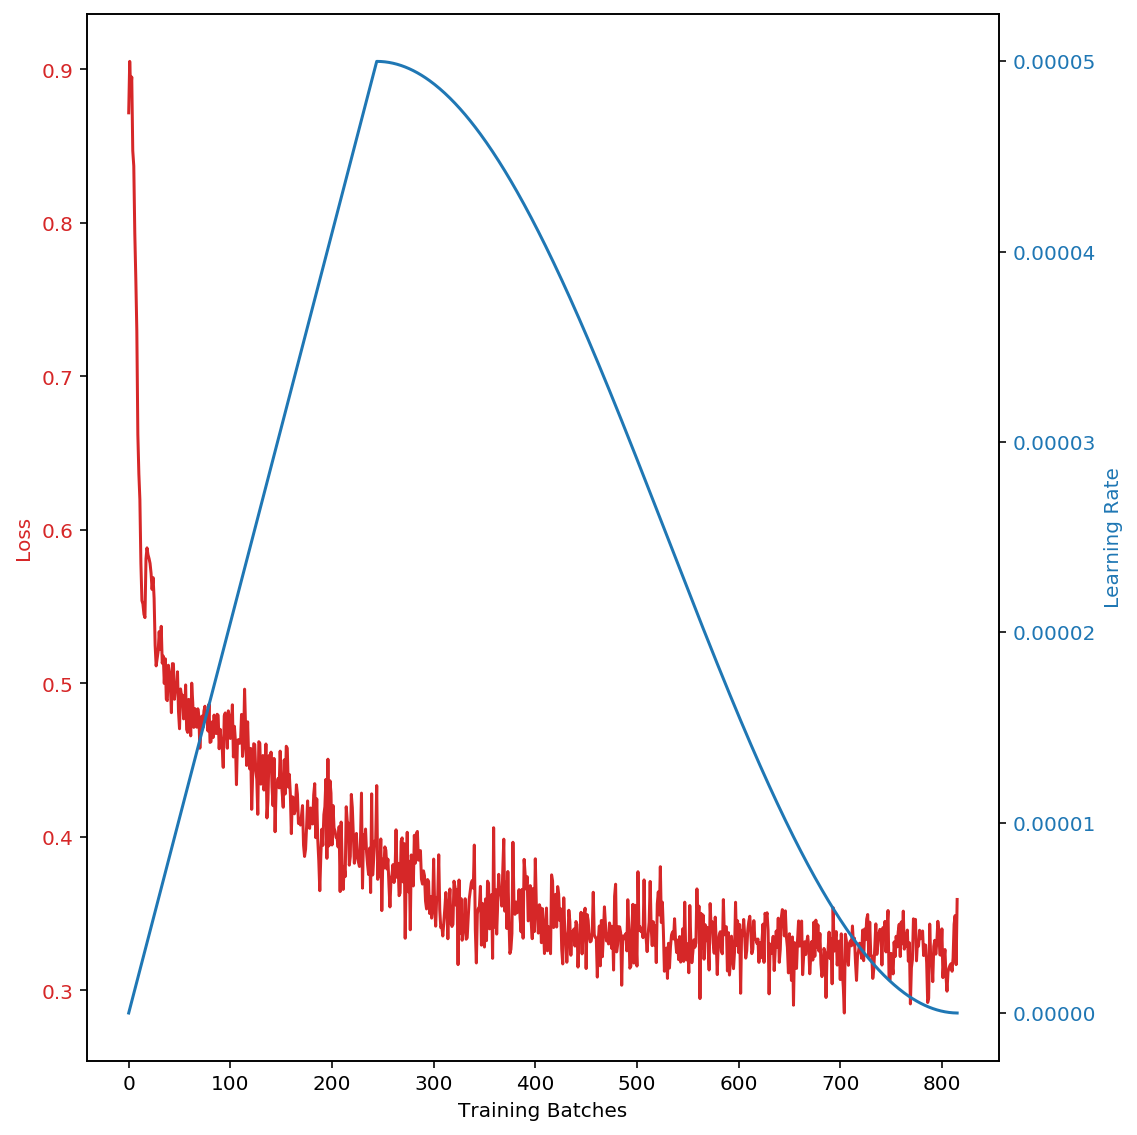

Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.792     0   1
1      0.119 0.818     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.506,"[0.4943177103996277, 0.5056822896003723]",1,0,0.458,"[0.5419405102729797, 0.45805948972702026]",0,1,0.417,"[0.5834930539131165, 0.41650694608688354]",0,0
1,0.480,"[0.519960343837738, 0.48003965616226196]",0,1,0.370,"[0.6301073431968689, 0.36989259719848633]",0,0,0.439,"[0.5610328912734985, 0.4389670789241791]",0,1
2,0.385,"[0.6153403520584106, 0.38465964794158936]",0,0,0.416,"[0.5844233632087708, 0.41557660698890686]",0,0,0.707,"[0.29274964332580566, 0.7072503566741943]",1,0
3,0.326,"[0.6741451621055603, 0.3258548676967621]",0,0,0.499,"[0.5005703568458557, 0.4994296133518219]",0,1,0.682,"[0.3184809982776642, 0.6815189719200134]",1,1
4,0.291,"[0.7093660831451416, 0.2906338572502136]",0,1,0.369,"[0.6306499242782593, 0.3693500757217407]",0,1,0.414,"[0.5855351686477661, 0.4144647717475891]",0,0


scores =  {'map': '0.6114', 'acc': '0.5680', 'auc': '0.6508'}


train   val
mean_or_std metric               
mean        map       0.780 0.611
            accuracy  0.771 0.568
            auc       0.850 0.651
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.835  0.801 0.817 5450.000     0.552  0.728 0.628 250.000
pos     0.668  0.717 0.692 3050.000     0.600  0.408 0.486 250.000

In [31]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.025,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

# 0.854	0.654 0.651 0.646 x2
# MLM = 0.854	0.646
# No focal 0.851	0.647 (0.766	0.556)


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  56 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.693817 LR = 0.00000149



Epoch =  2 Loss = 0.592762 LR = 0.00000298



Epoch =  3 Loss = 0.566228 LR = 0.00000447



Epoch =  4 Loss = 0.555877 LR = 0.00000596



Epoch =  5 Loss = 0.548087 LR = 0.00000746



Epoch =  6 Loss = 0.530008 LR = 0.00000895



Epoch =  7 Loss = 0.513579 LR = 0.00001044



Epoch =  8 Loss = 0.499346 LR = 0.00001193



Epoch =  9 Loss = 0.497599 LR = 0.00001342



Epoch =  10 Loss = 0.505649 LR = 0.00001491



Epoch =  11 Loss = 0.470327 LR = 0.00001640



Epoch =  12 Loss = 0.465575 LR = 0.00001789



Epoch =  13 Loss = 0.456832 LR = 0.00001939



Epoch =  14 Loss = 0.441019 LR = 0.00002088



Epoch =  15 Loss = 0.443088 LR = 0.00002237



Epoch =  16 Loss = 0.447570 LR = 0.00002386



Epoch =  17 Loss = 0.438798 LR = 0.00002500


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.678     0   1
1      0.140 0.718     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.326,"[0.6735860109329224, 0.32641392946243286]",0,1,0.321,"[0.6792784929275513, 0.32072144746780396]",0,0,0.407,"[0.5925323963165283, 0.4074675440788269]",0,1
1,0.552,"[0.4476003646850586, 0.5523996353149414]",1,1,0.395,"[0.6047577261924744, 0.39524227380752563]",0,0,0.111,"[0.888601541519165, 0.11139844357967377]",0,0
2,0.331,"[0.6685856580734253, 0.3314144015312195]",0,1,0.212,"[0.7884982824325562, 0.21150171756744385]",0,1,0.237,"[0.762617826461792, 0.23738214373588562]",0,1
3,0.289,"[0.7113529443740845, 0.28864702582359314]",0,0,0.136,"[0.8640451431274414, 0.13595479726791382]",0,0,0.417,"[0.5832287073135376, 0.4167712926864624]",0,0
4,0.305,"[0.6950263977050781, 0.3049735426902771]",0,1,0.612,"[0.38764163851737976, 0.6123583316802979]",1,1,0.143,"[0.8569101691246033, 0.14308983087539673]",0,0


scores =  {'map': '0.5963', 'acc': '0.5240', 'auc': '0.6231'}
Epoch =  17 Train = 0.784517 Val = 0.623120


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  18 Loss = 0.436490 LR = 0.00002494



Epoch =  19 Loss = 0.414530 LR = 0.00002480



Epoch =  20 Loss = 0.408522 LR = 0.00002458



Epoch =  21 Loss = 0.410029 LR = 0.00002429


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  22 Loss = 0.415834 LR = 0.00002392



Epoch =  23 Loss = 0.433877 LR = 0.00002347



Epoch =  24 Loss = 0.397888 LR = 0.00002296



Epoch =  25 Loss = 0.389034 LR = 0.00002238



Epoch =  26 Loss = 0.400461 LR = 0.00002174



Epoch =  27 Loss = 0.390971 LR = 0.00002103


Proba       Preds    
         min   max   min max
Labels                      
0      0.083 0.697     0   1
1      0.144 0.758     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.332,"[0.6675203442573547, 0.3324796259403229]",0,0,0.255,"[0.7454895377159119, 0.25451040267944336]",0,0,0.672,"[0.328235387802124, 0.6717645525932312]",1,0
1,0.220,"[0.7803990244865417, 0.21960094571113586]",0,0,0.341,"[0.6588400602340698, 0.3411599397659302]",0,1,0.504,"[0.496135950088501, 0.503864049911499]",1,1
2,0.373,"[0.6265850067138672, 0.37341493368148804]",0,1,0.515,"[0.48470839858055115, 0.5152915716171265]",1,1,0.392,"[0.608165979385376, 0.391834020614624]",0,1
3,0.384,"[0.616107165813446, 0.38389286398887634]",0,0,0.173,"[0.8266434669494629, 0.17335650324821472]",0,0,0.384,"[0.616107165813446, 0.38389286398887634]",0,1
4,0.268,"[0.7320501804351807, 0.2679498493671417]",0,0,0.251,"[0.7491154670715332, 0.2508845031261444]",0,1,0.220,"[0.7799413800239563, 0.22005857527256012]",0,1


scores =  {'map': '0.6022', 'acc': '0.5420', 'auc': '0.6313'}
Epoch =  27 Train = 0.816965 Val = 0.631280



Epoch =  28 Loss = 0.384910 LR = 0.00002027



Epoch =  29 Loss = 0.378276 LR = 0.00001947



Epoch =  30 Loss = 0.372948 LR = 0.00001861



Epoch =  31 Loss = 0.365685 LR = 0.00001772



Epoch =  32 Loss = 0.373271 LR = 0.00001680


Exception for:  keyboard | ' ' ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  33 Loss = 0.368499 LR = 0.00001584



Epoch =  34 Loss = 0.366455 LR = 0.00001487


Proba       Preds    
         min   max   min max
Labels                      
0      0.096 0.747     0   1
1      0.187 0.811     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.291,"[0.7089537382125854, 0.29104623198509216]",0,1,0.512,"[0.4882551431655884, 0.5117448568344116]",1,0,0.241,"[0.7586216926574707, 0.2413783073425293]",0,0
1,0.293,"[0.7069728374481201, 0.2930271625518799]",0,0,0.528,"[0.47187644243240356, 0.5281236171722412]",1,1,0.228,"[0.7722924947738647, 0.22770747542381287]",0,0
2,0.453,"[0.5474585294723511, 0.4525415003299713]",0,1,0.218,"[0.7819173336029053, 0.21808265149593353]",0,0,0.656,"[0.3436698615550995, 0.6563301086425781]",1,1
3,0.144,"[0.8560547828674316, 0.14394524693489075]",0,0,0.453,"[0.5474836826324463, 0.45251625776290894]",0,1,0.457,"[0.5432570576667786, 0.45674291253089905]",0,1
4,0.532,"[0.4680182933807373, 0.5319817066192627]",1,1,0.583,"[0.41734200716018677, 0.5826579332351685]",1,0,0.527,"[0.47262343764305115, 0.5273765325546265]",1,1


scores =  {'map': '0.6094', 'acc': '0.5500', 'auc': '0.6398'}
Epoch =  34 Train = 0.833769 Val = 0.639760



Epoch =  35 Loss = 0.363882 LR = 0.00001388



Epoch =  36 Loss = 0.359039 LR = 0.00001288



Epoch =  37 Loss = 0.369695 LR = 0.00001188



Epoch =  38 Loss = 0.355604 LR = 0.00001089



Epoch =  39 Loss = 0.354957 LR = 0.00000990



Epoch =  40 Loss = 0.353988 LR = 0.00000893



Epoch =  41 Loss = 0.353639 LR = 0.00000798


Proba       Preds    
         min   max   min max
Labels                      
0      0.069 0.801     0   1
1      0.184 0.779     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.388,"[0.6123794317245483, 0.38762056827545166]",0,0,0.603,"[0.3973381519317627, 0.6026618480682373]",1,1,0.657,"[0.3427031636238098, 0.6572967767715454]",1,0
1,0.518,"[0.4818495810031891, 0.5181503295898438]",1,1,0.604,"[0.3959037661552429, 0.6040961742401123]",1,0,0.425,"[0.5750235915184021, 0.42497631907463074]",0,0
2,0.516,"[0.48368215560913086, 0.5163177847862244]",1,1,0.590,"[0.4097056984901428, 0.5902942419052124]",1,1,0.289,"[0.7113732099533081, 0.2886267900466919]",0,0
3,0.434,"[0.5660718083381653, 0.43392816185951233]",0,1,0.624,"[0.37649106979370117, 0.6235089302062988]",1,1,0.353,"[0.6472706198692322, 0.35272935032844543]",0,0
4,0.340,"[0.6600748896598816, 0.339925080537796]",0,1,0.357,"[0.6432638764381409, 0.35673612356185913]",0,0,0.611,"[0.3893555700778961, 0.6106444001197815]",1,1


scores =  {'map': '0.6067', 'acc': '0.5680', 'auc': '0.6445'}
Epoch =  41 Train = 0.844079 Val = 0.644544



Epoch =  42 Loss = 0.347794 LR = 0.00000707



Epoch =  43 Loss = 0.355471 LR = 0.00000618



Epoch =  44 Loss = 0.349166 LR = 0.00000534



Epoch =  45 Loss = 0.353196 LR = 0.00000454



Epoch =  46 Loss = 0.342063 LR = 0.00000380



Epoch =  47 Loss = 0.348893 LR = 0.00000311


Proba       Preds    
         min   max   min max
Labels                      
0      0.058 0.800     0   1
1      0.150 0.787     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.509,"[0.4913639426231384, 0.5086359977722168]",1,1,0.226,"[0.773829460144043, 0.22617049515247345]",0,0,0.666,"[0.3336986005306244, 0.6663013696670532]",1,1
1,0.571,"[0.4292832314968109, 0.5707167387008667]",1,0,0.489,"[0.510711133480072, 0.489288866519928]",0,1,0.219,"[0.781286358833313, 0.21871358156204224]",0,1
2,0.242,"[0.7576575875282288, 0.24234238266944885]",0,0,0.502,"[0.49778491258621216, 0.5022151470184326]",1,0,0.443,"[0.5574558973312378, 0.4425440728664398]",0,1
3,0.384,"[0.6156567335128784, 0.3843432366847992]",0,0,0.440,"[0.5604334473609924, 0.43956655263900757]",0,1,0.321,"[0.6786003112792969, 0.3213997185230255]",0,1
4,0.190,"[0.809994101524353, 0.19000588357448578]",0,0,0.381,"[0.6188890933990479, 0.38111090660095215]",0,0,0.416,"[0.5836459398269653, 0.41635406017303467]",0,1


scores =  {'map': '0.6059', 'acc': '0.5560', 'auc': '0.6406'}
Epoch =  47 Train = 0.849852 Val = 0.640608



Epoch =  48 Loss = 0.345936 LR = 0.00000248



Epoch =  49 Loss = 0.349147 LR = 0.00000191



Epoch =  50 Loss = 0.343726 LR = 0.00000142



Epoch =  51 Loss = 0.344227 LR = 0.00000099


Proba       Preds    
         min   max   min max
Labels                      
0      0.057 0.801     0   1
1      0.141 0.790     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.306,"[0.6935570240020752, 0.30644291639328003]",0,0,0.320,"[0.6800438165664673, 0.3199561536312103]",0,1,0.402,"[0.5978609323501587, 0.4021390676498413]",0,1
1,0.361,"[0.6394314169883728, 0.3605685234069824]",0,0,0.543,"[0.45663270354270935, 0.5433672666549683]",1,0,0.535,"[0.4645266830921173, 0.5354733467102051]",1,1
2,0.346,"[0.6539775729179382, 0.346022367477417]",0,1,0.434,"[0.5659788846969604, 0.43402108550071716]",0,1,0.205,"[0.794876754283905, 0.2051231861114502]",0,0
3,0.181,"[0.8190778493881226, 0.18092209100723267]",0,0,0.284,"[0.7164740562438965, 0.28352588415145874]",0,1,0.286,"[0.7143470048904419, 0.28565293550491333]",0,0
4,0.513,"[0.4872809648513794, 0.5127189755439758]",1,0,0.352,"[0.6481639742851257, 0.35183602571487427]",0,0,0.366,"[0.634092390537262, 0.36590757966041565]",0,0


scores =  {'map': '0.6103', 'acc': '0.5660', 'auc': '0.6446'}
Epoch =  51 Train = 0.850294 Val = 0.644576



Epoch =  52 Loss = 0.341734 LR = 0.00000064



Epoch =  53 Loss = 0.340628 LR = 0.00000036



Epoch =  54 Loss = 0.344826 LR = 0.00000016


Proba       Preds    
         min   max   min max
Labels                      
0      0.065 0.827     0   1
1      0.159 0.819     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.283,"[0.7166962623596191, 0.28330370783805847]",0,0,0.578,"[0.42221367359161377, 0.5777862071990967]",1,1,0.501,"[0.4988391101360321, 0.5011608600616455]",1,0
1,0.404,"[0.5958144068717957, 0.40418556332588196]",0,1,0.424,"[0.5762948989868164, 0.4237050712108612]",0,1,0.792,"[0.20836807787418365, 0.7916319370269775]",1,0
2,0.111,"[0.8886725902557373, 0.11132741719484329]",0,0,0.320,"[0.6800625324249268, 0.319937527179718]",0,0,0.521,"[0.47883036732673645, 0.5211695432662964]",1,0
3,0.580,"[0.4199727177619934, 0.5800272822380066]",1,1,0.153,"[0.8470019102096558, 0.15299810469150543]",0,0,0.258,"[0.7415542006492615, 0.25844573974609375]",0,1
4,0.402,"[0.5984390377998352, 0.4015609323978424]",0,1,0.426,"[0.5743200778961182, 0.42567992210388184]",0,1,0.628,"[0.37178856134414673, 0.6282113790512085]",1,0


scores =  {'map': '0.6105', 'acc': '0.5680', 'auc': '0.6446'}
Epoch =  54 Train = 0.850712 Val = 0.644576



Epoch =  55 Loss = 0.340601 LR = 0.00000004



Epoch =  56 Loss = 0.342802 LR = 0.00000000



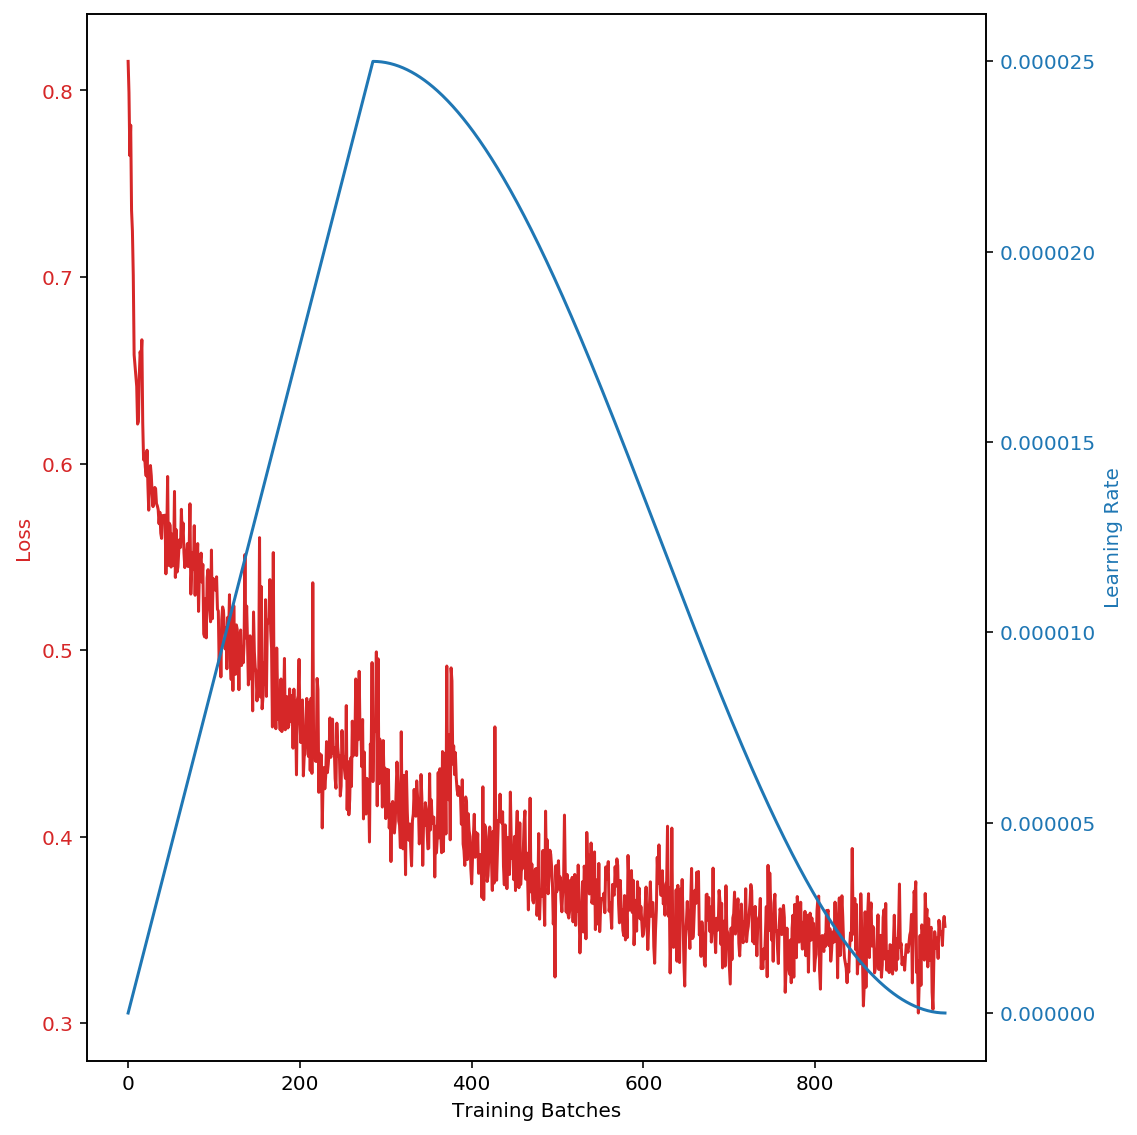

Proba       Preds    
         min   max   min max
Labels                      
0      0.064 0.824     0   1
1      0.157 0.815     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.226,"[0.7740835547447205, 0.22591647505760193]",0,0,0.264,"[0.7355028986930847, 0.2644970715045929]",0,0,0.619,"[0.38055098056793213, 0.6194489598274231]",1,1
1,0.467,"[0.5330854058265686, 0.4669145345687866]",0,1,0.228,"[0.7720579504966736, 0.22794204950332642]",0,0,0.586,"[0.41422411799430847, 0.5857758522033691]",1,1
2,0.425,"[0.5747837424278259, 0.4252162277698517]",0,1,0.459,"[0.5409589409828186, 0.4590410590171814]",0,0,0.399,"[0.600562572479248, 0.3994373679161072]",0,1
3,0.522,"[0.47813206911087036, 0.5218679308891296]",1,0,0.266,"[0.7335094213485718, 0.26649054884910583]",0,1,0.434,"[0.5657378435134888, 0.43426206707954407]",0,0
4,0.375,"[0.6249487400054932, 0.37505120038986206]",0,0,0.594,"[0.4062751531600952, 0.5937248468399048]",1,1,0.428,"[0.571652889251709, 0.428347110748291]",0,1


scores =  {'map': '0.6101', 'acc': '0.5620', 'auc': '0.6444'}


train   val
mean_or_std metric               
mean        map       0.777 0.610
            accuracy  0.761 0.562
            auc       0.851 0.644
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.846  0.767 0.804 5450.000     0.550  0.684 0.610 250.000
pos     0.643  0.750 0.692 3050.000     0.582  0.440 0.501 250.000

In [32]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/4,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 28
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r3, p3 = results, prfs
results
prfs

# 0.853	0.655 (0.765	0.570)
# 0.863	0.651 (0.778	0.570)


### Train Head First

In [6]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process


preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


Pick stored Model /home/ahemf/cache/distilbert-smclr Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  12 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.738713 LR = 0.00002787



Epoch =  2 Loss = 0.610968 LR = 0.00005574



Epoch =  3 Loss = 0.559632 LR = 0.00008361



Epoch =  4 Loss = 0.557351 LR = 0.00009941



Epoch =  5 Loss = 0.521501 LR = 0.00009321



Epoch =  6 Loss = 0.500287 LR = 0.00008105



Epoch =  7 Loss = 0.482960 LR = 0.00006461



Epoch =  8 Loss = 0.481879 LR = 0.00004616



Epoch =  9 Loss = 0.459251 LR = 0.00002824



Epoch =  10 Loss = 0.453757 LR = 0.00001331



Epoch =  11 Loss = 0.443904 LR = 0.00000345



Epoch =  12 Loss = 0.439491 LR = 0.00000000



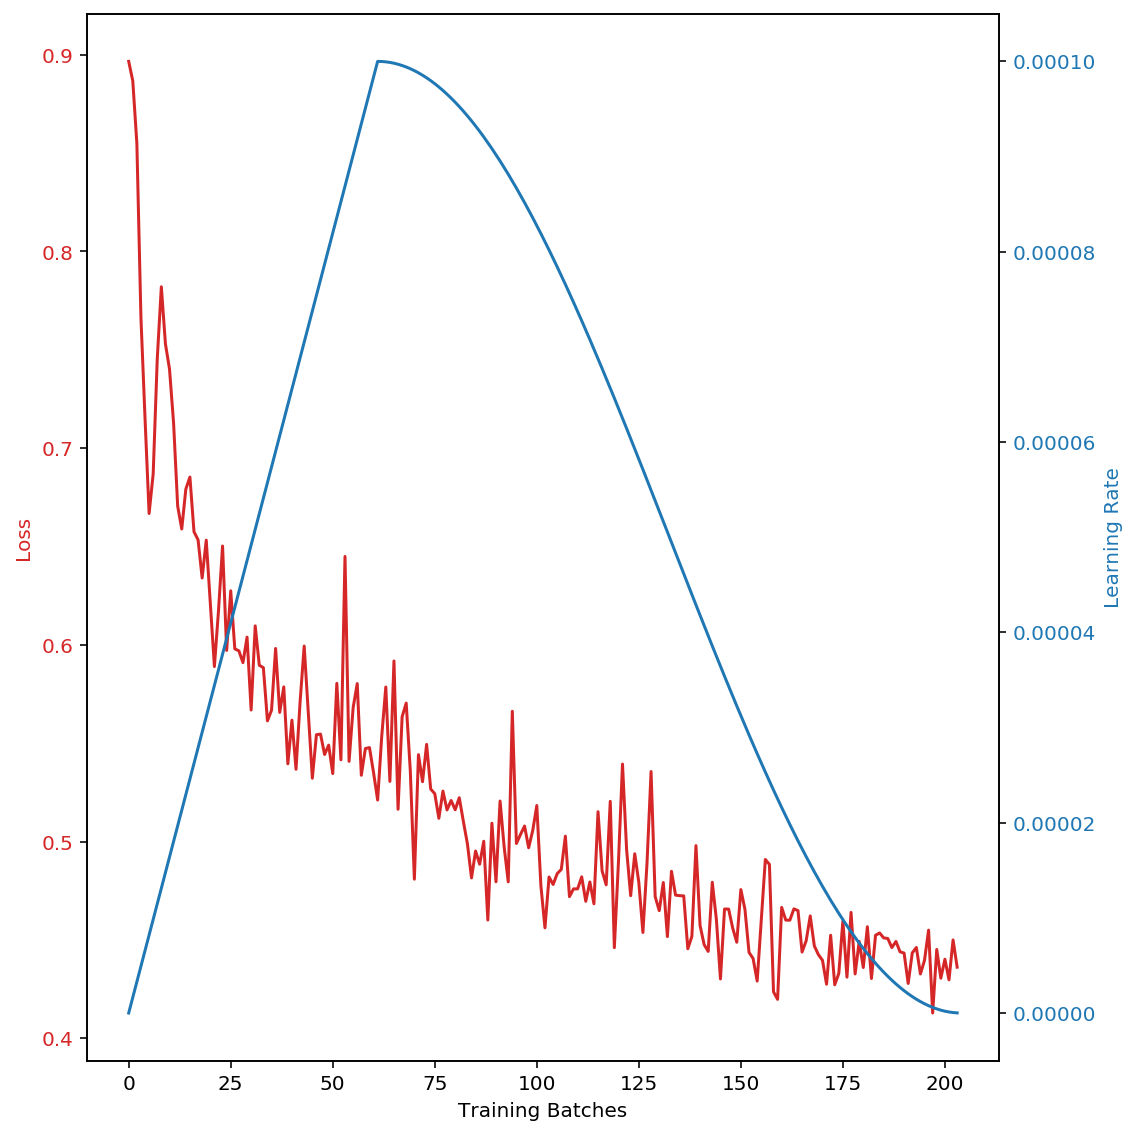

Proba       Preds    
         min   max   min max
Labels                      
0      0.355 0.615     0   1
1      0.355 0.617     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.526,"[0.4735367000102997, 0.5264633297920227]",1,0,0.535,"[0.4650432765483856, 0.534956693649292]",1,1,0.563,"[0.43711069226264954, 0.5628893375396729]",1,1
1,0.528,"[0.47220131754875183, 0.5277987122535706]",1,0,0.522,"[0.47816452383995056, 0.5218355059623718]",1,0,0.487,"[0.513365626335144, 0.48663443326950073]",0,1
2,0.400,"[0.5996314883232117, 0.40036848187446594]",0,0,0.525,"[0.4752640426158905, 0.5247359871864319]",1,0,0.491,"[0.5090277791023254, 0.4909721612930298]",0,1
3,0.468,"[0.531702995300293, 0.46829697489738464]",0,0,0.458,"[0.5416489243507385, 0.4583510756492615]",0,0,0.447,"[0.5525088310241699, 0.4474911093711853]",0,1
4,0.585,"[0.4153313636779785, 0.5846686363220215]",1,1,0.483,"[0.5167866349220276, 0.48321333527565]",0,0,0.488,"[0.5115104913711548, 0.4884895086288452]",0,1


scores =  {'map': '0.5963', 'acc': '0.5560', 'auc': '0.6148'}


train   val
mean_or_std metric               
mean        map       0.608 0.596
            accuracy  0.697 0.556
            auc       0.731 0.615
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.753  0.785 0.768 5450.000     0.540  0.752 0.629 250.000
pos     0.584  0.540 0.561 3050.000     0.592  0.360 0.448 250.000

Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.441085 LR = 0.00000209



Epoch =  2 Loss = 0.443661 LR = 0.00000418



Epoch =  3 Loss = 0.443330 LR = 0.00000627



Epoch =  4 Loss = 0.439669 LR = 0.00000836



Epoch =  5 Loss = 0.440428 LR = 0.00001045



Epoch =  6 Loss = 0.445924 LR = 0.00001254



Epoch =  7 Loss = 0.437291 LR = 0.00001463



Epoch =  8 Loss = 0.444341 LR = 0.00001672



Epoch =  9 Loss = 0.443769 LR = 0.00001881



Epoch =  10 Loss = 0.441471 LR = 0.00002090



Epoch =  11 Loss = 0.430093 LR = 0.00002299


Exception for:  keyboard | '' | ['keyboard' 'char_substitute'] argument of type 'NoneType' is not iterable

Epoch =  12 Loss = 0.423778 LR = 0.00002508



Epoch =  13 Loss = 0.418867 LR = 0.00002717



Epoch =  14 Loss = 0.416631 LR = 0.00002926



Epoch =  15 Loss = 0.410843 LR = 0.00002997


Proba       Preds    
         min   max   min max
Labels                      
0      0.316 0.646     0   1
1      0.348 0.654     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.367,"[0.6325860619544983, 0.3674139380455017]",0,1,0.512,"[0.48842325806617737, 0.5115767121315002]",1,1,0.384,"[0.6155019998550415, 0.3844980299472809]",0,0
1,0.522,"[0.47791266441345215, 0.5220872759819031]",1,0,0.487,"[0.5125700831413269, 0.4874299466609955]",0,1,0.489,"[0.5114601850509644, 0.48853981494903564]",0,1
2,0.610,"[0.3904711604118347, 0.6095288395881653]",1,1,0.402,"[0.598421573638916, 0.4015783965587616]",0,1,0.438,"[0.5615107417106628, 0.4384891986846924]",0,1
3,0.461,"[0.5393521189689636, 0.4606478810310364]",0,1,0.456,"[0.5443424582481384, 0.4556575119495392]",0,0,0.588,"[0.41155868768692017, 0.5884413123130798]",1,1
4,0.447,"[0.5532248616218567, 0.4467751085758209]",0,0,0.562,"[0.4378991723060608, 0.562100887298584]",1,1,0.363,"[0.6372828483581543, 0.3627171218395233]",0,1


scores =  {'map': '0.6030', 'acc': '0.5620', 'auc': '0.6306'}
Epoch =  15 Train = 0.792483 Val = 0.630608



Epoch =  16 Loss = 0.402480 LR = 0.00002982



Epoch =  17 Loss = 0.413041 LR = 0.00002954



Epoch =  18 Loss = 0.410613 LR = 0.00002914



Epoch =  19 Loss = 0.404241 LR = 0.00002861



Epoch =  20 Loss = 0.404645 LR = 0.00002796



Epoch =  21 Loss = 0.393777 LR = 0.00002720


Proba       Preds    
         min   max   min max
Labels                      
0      0.304 0.637     0   1
1      0.342 0.648     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.535,"[0.46536582708358765, 0.5346341133117676]",1,0,0.432,"[0.5683023929595947, 0.43169763684272766]",0,0,0.468,"[0.5320965647697449, 0.46790337562561035]",0,0
1,0.535,"[0.4651276171207428, 0.5348724126815796]",1,0,0.483,"[0.5171895027160645, 0.48281046748161316]",0,1,0.584,"[0.41558101773262024, 0.5844190120697021]",1,1
2,0.362,"[0.6381010413169861, 0.36189892888069153]",0,0,0.488,"[0.5120396018028259, 0.4879603385925293]",0,0,0.492,"[0.5075851082801819, 0.4924148619174957]",0,1
3,0.537,"[0.4626433253288269, 0.5373567342758179]",1,1,0.338,"[0.6624283194541931, 0.3375716507434845]",0,0,0.486,"[0.513862133026123, 0.48613792657852173]",0,1
4,0.475,"[0.5247302651405334, 0.47526970505714417]",0,1,0.401,"[0.5988622307777405, 0.4011377990245819]",0,0,0.553,"[0.44693487882614136, 0.5530651211738586]",1,1


scores =  {'map': '0.6161', 'acc': '0.5760', 'auc': '0.6466'}
Epoch =  21 Train = 0.818184 Val = 0.646608



Epoch =  22 Loss = 0.397122 LR = 0.00002634



Epoch =  23 Loss = 0.397337 LR = 0.00002537



Epoch =  24 Loss = 0.393543 LR = 0.00002432



Epoch =  25 Loss = 0.387896 LR = 0.00002318



Epoch =  26 Loss = 0.391027 LR = 0.00002197



Epoch =  27 Loss = 0.389562 LR = 0.00002070



Epoch =  28 Loss = 0.383742 LR = 0.00001938



Epoch =  29 Loss = 0.386275 LR = 0.00001803



Epoch =  30 Loss = 0.389742 LR = 0.00001664



Epoch =  31 Loss = 0.387277 LR = 0.00001525


Proba       Preds    
         min   max   min max
Labels                      
0      0.286 0.633     0   1
1      0.311 0.657     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.457,"[0.542683482170105, 0.45731648802757263]",0,0,0.474,"[0.5259308815002441, 0.47406908869743347]",0,1,0.410,"[0.5901103615760803, 0.4098896086215973]",0,1
1,0.337,"[0.6634703278541565, 0.3365296721458435]",0,1,0.461,"[0.5394266843795776, 0.46057331562042236]",0,1,0.425,"[0.5750981569290161, 0.4249018132686615]",0,0
2,0.358,"[0.641610860824585, 0.35838910937309265]",0,1,0.472,"[0.5283817052841187, 0.47161832451820374]",0,0,0.399,"[0.6013620495796204, 0.39863795042037964]",0,1
3,0.390,"[0.610408365726471, 0.38959160447120667]",0,1,0.441,"[0.5593113303184509, 0.4406886696815491]",0,0,0.399,"[0.6005259156227112, 0.39947405457496643]",0,0
4,0.438,"[0.5618407130241394, 0.438159316778183]",0,1,0.346,"[0.6541330814361572, 0.3458668887615204]",0,0,0.405,"[0.5947608947753906, 0.4052390456199646]",0,0


scores =  {'map': '0.6170', 'acc': '0.5460', 'auc': '0.6489'}
Epoch =  31 Train = 0.838758 Val = 0.648896



Epoch =  32 Loss = 0.381163 LR = 0.00001385



Epoch =  33 Loss = 0.378819 LR = 0.00001246



Epoch =  34 Loss = 0.373993 LR = 0.00001109



Epoch =  35 Loss = 0.374647 LR = 0.00000976



Epoch =  36 Loss = 0.367129 LR = 0.00000847



Epoch =  37 Loss = 0.369923 LR = 0.00000724



Epoch =  38 Loss = 0.375288 LR = 0.00000608



Epoch =  39 Loss = 0.375523 LR = 0.00000499



Epoch =  40 Loss = 0.372976 LR = 0.00000399



Epoch =  41 Loss = 0.369293 LR = 0.00000309


Proba       Preds    
         min   max   min max
Labels                      
0      0.281 0.644     0   1
1      0.301 0.671     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.407,"[0.5930063724517822, 0.4069935381412506]",0,1,0.454,"[0.5455315113067627, 0.4544684886932373]",0,1,0.530,"[0.47049129009246826, 0.5295087099075317]",1,1
1,0.482,"[0.5175264477729797, 0.48247361183166504]",0,0,0.348,"[0.6520346403121948, 0.3479653596878052]",0,0,0.343,"[0.6569052934646606, 0.34309473633766174]",0,1
2,0.405,"[0.5952909588813782, 0.4047090411186218]",0,1,0.394,"[0.6061041951179504, 0.39389586448669434]",0,0,0.551,"[0.44947054982185364, 0.550529420375824]",1,0
3,0.527,"[0.4725092053413391, 0.5274907946586609]",1,1,0.387,"[0.6128244996070862, 0.38717547059059143]",0,0,0.607,"[0.3925632834434509, 0.6074367165565491]",1,0
4,0.568,"[0.43180036544799805, 0.5681995749473572]",1,0,0.388,"[0.6124295592308044, 0.38757041096687317]",0,0,0.340,"[0.6597380042076111, 0.3402620851993561]",0,0


scores =  {'map': '0.6156', 'acc': '0.5580', 'auc': '0.6487'}
Epoch =  41 Train = 0.849497 Val = 0.648720



Epoch =  42 Loss = 0.373767 LR = 0.00000229



Epoch =  43 Loss = 0.369119 LR = 0.00000161



Epoch =  44 Loss = 0.369855 LR = 0.00000103



Epoch =  45 Loss = 0.371103 LR = 0.00000058



Epoch =  46 Loss = 0.366016 LR = 0.00000026


Proba       Preds    
         min   max   min max
Labels                      
0      0.284 0.665     0   1
1      0.312 0.687     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.486,"[0.514350414276123, 0.48564958572387695]",0,0,0.343,"[0.6573495268821716, 0.34265050292015076]",0,0,0.343,"[0.6573495268821716, 0.34265050292015076]",0,0
1,0.506,"[0.4943529963493347, 0.5056470632553101]",1,1,0.377,"[0.6233248114585876, 0.37667524814605713]",0,0,0.608,"[0.39209264516830444, 0.6079072952270508]",1,1
2,0.432,"[0.5679031610488892, 0.43209680914878845]",0,0,0.594,"[0.40642598271369934, 0.5935739874839783]",1,0,0.539,"[0.46112823486328125, 0.5388717651367188]",1,1
3,0.572,"[0.42800086736679077, 0.5719990730285645]",1,0,0.561,"[0.4388299882411957, 0.5611700415611267]",1,1,0.445,"[0.5554450750350952, 0.44455486536026]",0,1
4,0.364,"[0.6359081864356995, 0.3640918731689453]",0,0,0.564,"[0.43619394302368164, 0.5638059973716736]",1,1,0.362,"[0.6382010579109192, 0.3617989420890808]",0,0


scores =  {'map': '0.6185', 'acc': '0.5680', 'auc': '0.6509'}
Epoch =  46 Train = 0.850137 Val = 0.650912



Epoch =  47 Loss = 0.368400 LR = 0.00000007



Epoch =  48 Loss = 0.363268 LR = 0.00000000



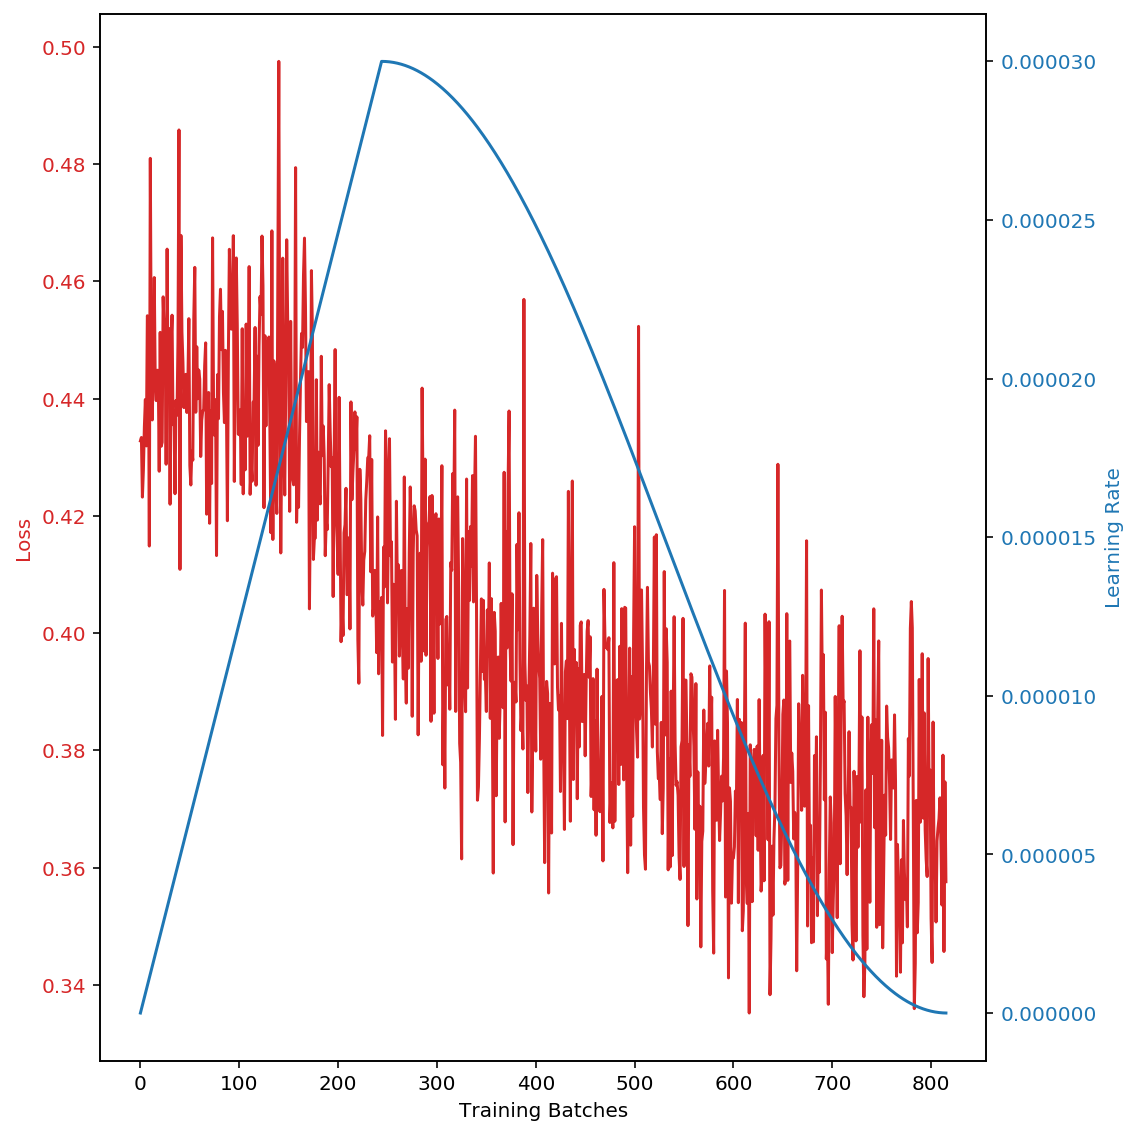

Proba       Preds    
         min   max   min max
Labels                      
0      0.284 0.664     0   1
1      0.311 0.686     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.404,"[0.5963168740272522, 0.4036830961704254]",0,0,0.404,"[0.595970094203949, 0.40402987599372864]",0,1,0.482,"[0.5178923606872559, 0.4821076989173889]",0,1
1,0.542,"[0.4581984579563141, 0.5418015122413635]",1,0,0.379,"[0.6212469339370728, 0.37875306606292725]",0,0,0.592,"[0.4077247381210327, 0.5922752618789673]",1,0
2,0.530,"[0.4699881672859192, 0.5300118923187256]",1,1,0.428,"[0.5715823769569397, 0.4284176230430603]",0,1,0.459,"[0.5407665371894836, 0.45923346281051636]",0,1
3,0.534,"[0.46592047810554504, 0.5340795516967773]",1,1,0.432,"[0.5682637095451355, 0.4317362606525421]",0,0,0.462,"[0.5378825664520264, 0.462117463350296]",0,1
4,0.404,"[0.595970094203949, 0.40402987599372864]",0,0,0.651,"[0.34947267174720764, 0.65052729845047]",1,1,0.465,"[0.5353362560272217, 0.4646637737751007]",0,0


scores =  {'map': '0.6187', 'acc': '0.5620', 'auc': '0.6509'}


train   val
mean_or_std metric               
mean        map       0.776 0.619
            accuracy  0.767 0.562
            auc       0.850 0.651
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.838  0.789 0.813 5450.000     0.546  0.740 0.628 250.000
pos     0.659  0.728 0.691 3050.000     0.596  0.384 0.467 250.000

In [10]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-smclr',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 24
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 21, 31, 41, 46, 51, 54, 62],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False,
)
r4, p4 = results, prfs
results
prfs

# 48-96
# 0.842	0.658 (0.767	0.572)
# 0.847	0.652 (0.766	0.574)

# Very high W/C
# 0.841	0.652 (0.760	0.570)
# 0.840	0.653 (0.759	0.576)
# 0.839	0.650 (0.760	0.568)
# 0.842	0.645 (0.762	0.570)
# 0.839	0.653 (0.761	0.574)


# # No stops + Very High W/C Reg
# 0.836	0.652 (0.754	0.588)
# 0.839	0.650 (0.762	0.576)

# 48-64 0.0 gauss
# 0.848	0.658 (0.768	0.578)
# 0.849	0.656 (0.766	0.570)


# SimCLR
# 0.856	0.657 (0.767	0.590)
# 0.859	0.654 (0.778	0.568)


## Multi-eval decoder ensemble

# Predict

In [11]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process


preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=False,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


Pick stored Model /home/ahemf/cache/distilbert-smclr Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Doing Special split for FB 
 Train Labels = 0    5040
1    2640
Name: label, dtype: int64 Test Labels = 1    660
0    660
Name: label, dtype: int64
Autocast =  True Epochs =  12 Divisor = 2 Examples = 3840 Batch Size =  256
Training Samples =  7680 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.771263 LR = 0.00002778



Epoch =  2 Loss = 0.609954 LR = 0.00005556



Epoch =  3 Loss = 0.543983 LR = 0.00008333



Epoch =  4 Loss = 0.508292 LR = 0.00009944



Epoch =  5 Loss = 0.477692 LR = 0.00009330



Epoch =  6 Loss = 0.457889 LR = 0.00008117



Epoch =  7 Loss = 0.439408 LR = 0.00006474



Epoch =  8 Loss = 0.432655 LR = 0.00004626



Epoch =  9 Loss = 0.420696 LR = 0.00002831



Epoch =  10 Loss = 0.409511 LR = 0.00001335



Epoch =  11 Loss = 0.408116 LR = 0.00000346



Epoch =  12 Loss = 0.404265 LR = 0.00000000



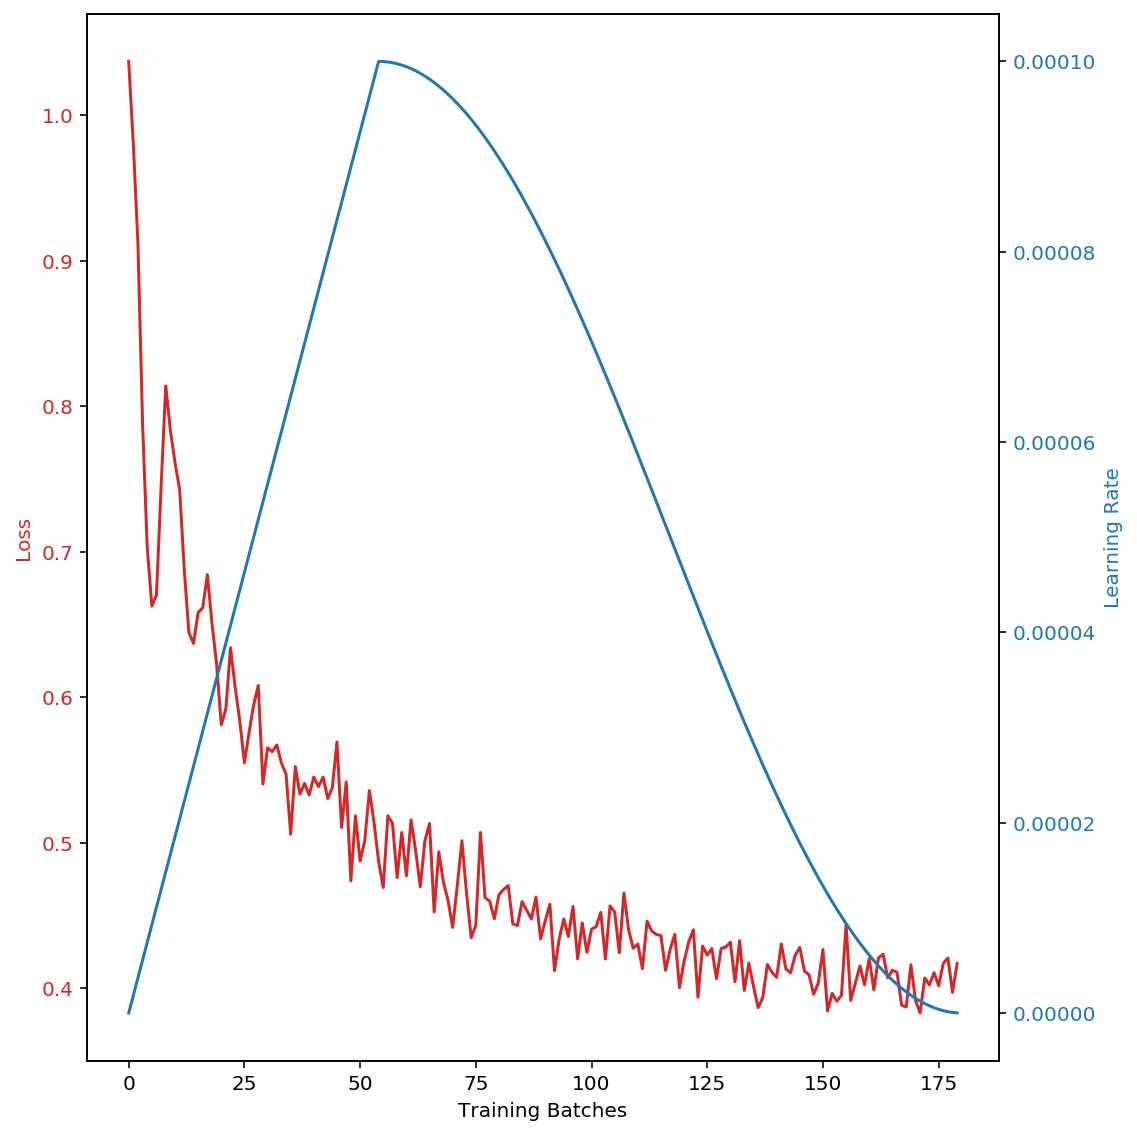

Proba       Preds    
         min   max   min max
Labels                      
0      0.376 0.605     0   1
1      0.380 0.661     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.420,"[0.5802899599075317, 0.41971009969711304]",0,1,0.491,"[0.5092260241508484, 0.49077391624450684]",0,1,0.598,"[0.4023689925670624, 0.5976309776306152]",1,0
1,0.477,"[0.5228109955787659, 0.4771890342235565]",0,1,0.496,"[0.5042256712913513, 0.4957742989063263]",0,1,0.565,"[0.435168981552124, 0.564831018447876]",1,1
2,0.470,"[0.529509425163269, 0.47049057483673096]",0,0,0.492,"[0.5079012513160706, 0.49209877848625183]",0,1,0.451,"[0.5492691993713379, 0.4507308602333069]",0,1
3,0.450,"[0.5501400232315063, 0.44985994696617126]",0,0,0.435,"[0.5649463534355164, 0.43505358695983887]",0,0,0.508,"[0.49235501885414124, 0.5076450705528259]",1,1
4,0.509,"[0.49142956733703613, 0.5085704326629639]",1,1,0.544,"[0.455551415681839, 0.5444486141204834]",1,0,0.492,"[0.5084567666053772, 0.4915432631969452]",0,1


scores =  {'map': '0.6911', 'acc': '0.6356', 'auc': '0.6877'}


train   val
mean_or_std metric               
mean        map       0.589 0.691
            accuracy  0.683 0.636
            auc       0.732 0.688
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.781  0.719 0.749 5040.000     0.622  0.689 0.654 660.000
pos     0.534  0.614 0.571 2640.000     0.652  0.582 0.615 660.000

In [12]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 6
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-smclr',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


Autocast =  True Epochs =  48 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1



Epoch =  1 Loss = 0.404239 LR = 0.00000208



Epoch =  2 Loss = 0.405183 LR = 0.00000417



Epoch =  3 Loss = 0.401372 LR = 0.00000625



Epoch =  4 Loss = 0.400346 LR = 0.00000834



Epoch =  5 Loss = 0.401277 LR = 0.00001042



Epoch =  6 Loss = 0.395569 LR = 0.00001251



Epoch =  7 Loss = 0.394966 LR = 0.00001459



Epoch =  8 Loss = 0.392075 LR = 0.00001668



Epoch =  9 Loss = 0.394978 LR = 0.00001876



Epoch =  10 Loss = 0.389038 LR = 0.00002085



Epoch =  11 Loss = 0.395689 LR = 0.00002293



Epoch =  12 Loss = 0.381373 LR = 0.00002502



Epoch =  13 Loss = 0.381048 LR = 0.00002710



Epoch =  14 Loss = 0.374892 LR = 0.00002919



Epoch =  15 Loss = 0.373917 LR = 0.00002998


Proba       Preds    
         min   max   min max
Labels                      
0      0.351 0.626     0   1
1      0.345 0.630     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.401,"[0.5990007519721985, 0.4009992480278015]",0,0,0.393,"[0.6070825457572937, 0.3929174840450287]",0,0,0.437,"[0.5631043910980225, 0.4368956387042999]",0,0
1,0.493,"[0.5066052079200745, 0.49339476227760315]",0,0,0.494,"[0.5060647130012512, 0.4939352571964264]",0,0,0.545,"[0.4554622769355774, 0.5445376634597778]",1,1
2,0.471,"[0.5289835929870605, 0.4710163474082947]",0,1,0.458,"[0.5415749549865723, 0.4584250748157501]",0,0,0.442,"[0.5575950145721436, 0.44240492582321167]",0,1
3,0.460,"[0.5401925444602966, 0.4598073959350586]",0,0,0.571,"[0.42851200699806213, 0.5714879631996155]",1,0,0.414,"[0.5856658220291138, 0.41433417797088623]",0,0
4,0.600,"[0.39981499314308167, 0.600184977054596]",1,0,0.437,"[0.5631043910980225, 0.4368956387042999]",0,0,0.509,"[0.4914793074131012, 0.5085206627845764]",1,1


scores =  {'map': '0.6226', 'acc': '0.5720', 'auc': '0.6431'}
Epoch =  15 Train = 0.746247 Val = 0.643064



Epoch =  16 Loss = 0.372774 LR = 0.00002983



Epoch =  17 Loss = 0.372886 LR = 0.00002956



Epoch =  18 Loss = 0.376798 LR = 0.00002915



Epoch =  19 Loss = 0.371100 LR = 0.00002863



Epoch =  20 Loss = 0.386658 LR = 0.00002798



Epoch =  21 Loss = 0.360640 LR = 0.00002723



Epoch =  22 Loss = 0.359345 LR = 0.00002636



Epoch =  23 Loss = 0.358839 LR = 0.00002540



Epoch =  24 Loss = 0.358016 LR = 0.00002434



Epoch =  25 Loss = 0.360724 LR = 0.00002321



Epoch =  26 Loss = 0.350446 LR = 0.00002200


Exception for:  keyboard | ? | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  27 Loss = 0.356163 LR = 0.00002073



Epoch =  28 Loss = 0.358777 LR = 0.00001941



Epoch =  29 Loss = 0.348456 LR = 0.00001806



Epoch =  30 Loss = 0.349195 LR = 0.00001667



Epoch =  31 Loss = 0.353381 LR = 0.00001527



Epoch =  32 Loss = 0.345294 LR = 0.00001387


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  33 Loss = 0.348892 LR = 0.00001248


Exception for:  keyboard | ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  34 Loss = 0.349446 LR = 0.00001111


Proba       Preds    
         min   max   min max
Labels                      
0      0.295 0.581     0   1
1      0.317 0.662     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.394,"[0.6058804392814636, 0.3941195607185364]",0,0,0.549,"[0.4508642554283142, 0.5491357445716858]",1,1,0.490,"[0.510456919670105, 0.48954302072525024]",0,1
1,0.441,"[0.5592657327651978, 0.44073429703712463]",0,1,0.343,"[0.6567496061325073, 0.34325042366981506]",0,0,0.473,"[0.5270981192588806, 0.4729018807411194]",0,0
2,0.599,"[0.40134191513061523, 0.5986580848693848]",1,1,0.348,"[0.6524506211280823, 0.34754934906959534]",0,0,0.481,"[0.5194804072380066, 0.4805196225643158]",0,0
3,0.378,"[0.6217790842056274, 0.37822097539901733]",0,1,0.439,"[0.5605262517929077, 0.4394737780094147]",0,1,0.295,"[0.7051701545715332, 0.2948299050331116]",0,0
4,0.335,"[0.6650272011756897, 0.3349727988243103]",0,0,0.459,"[0.5409442186355591, 0.45905572175979614]",0,1,0.346,"[0.6543611288070679, 0.34563887119293213]",0,1


scores =  {'map': '0.7173', 'acc': '0.6000', 'auc': '0.7216'}
Epoch =  34 Train = 0.797564 Val = 0.721584



Epoch =  35 Loss = 0.351472 LR = 0.00000978



Epoch =  36 Loss = 0.343847 LR = 0.00000849



Epoch =  37 Loss = 0.342745 LR = 0.00000725



Epoch =  38 Loss = 0.341905 LR = 0.00000609



Epoch =  39 Loss = 0.341733 LR = 0.00000500



Epoch =  40 Loss = 0.340387 LR = 0.00000400



Epoch =  41 Loss = 0.344112 LR = 0.00000310



Epoch =  42 Loss = 0.341887 LR = 0.00000230


Proba       Preds    
         min   max   min max
Labels                      
0      0.294 0.637     0   1
1      0.371 0.677     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.456,"[0.5440320372581482, 0.4559680223464966]",0,1,0.479,"[0.5207310318946838, 0.47926899790763855]",0,1,0.509,"[0.4914156496524811, 0.5085843801498413]",1,1
1,0.466,"[0.5343771576881409, 0.4656228721141815]",0,0,0.349,"[0.6508188247680664, 0.349181205034256]",0,0,0.436,"[0.5643619298934937, 0.43563807010650635]",0,1
2,0.403,"[0.5972421169281006, 0.4027579128742218]",0,0,0.438,"[0.5617128610610962, 0.4382871389389038]",0,0,0.523,"[0.4770146608352661, 0.5229852795600891]",1,0
3,0.441,"[0.5591956973075867, 0.44080424308776855]",0,1,0.302,"[0.6980944871902466, 0.3019055128097534]",0,0,0.479,"[0.5207310318946838, 0.47926899790763855]",0,1
4,0.389,"[0.6108554601669312, 0.38914456963539124]",0,0,0.531,"[0.4685154855251312, 0.5314844846725464]",1,0,0.400,"[0.5998764038085938, 0.40012356638908386]",0,0


scores =  {'map': '0.6515', 'acc': '0.5860', 'auc': '0.6811'}
Epoch =  42 Train = 0.805181 Val = 0.681136



Epoch =  43 Loss = 0.344554 LR = 0.00000161



Epoch =  44 Loss = 0.343221 LR = 0.00000104



Epoch =  45 Loss = 0.338490 LR = 0.00000059



Epoch =  46 Loss = 0.339573 LR = 0.00000026


Proba       Preds    
         min   max   min max
Labels                      
0      0.297 0.637     0   1
1      0.366 0.652     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.559,"[0.4410979747772217, 0.5589020848274231]",1,0,0.441,"[0.5590546131134033, 0.4409453868865967]",0,1,0.386,"[0.6141895055770874, 0.38581040501594543]",0,0
1,0.324,"[0.6755601763725281, 0.32443976402282715]",0,0,0.435,"[0.5651195645332336, 0.4348803758621216]",0,0,0.537,"[0.46339190006256104, 0.536608099937439]",1,0
2,0.430,"[0.5696507692337036, 0.4303492307662964]",0,0,0.474,"[0.5264424085617065, 0.47355762124061584]",0,1,0.511,"[0.48890942335128784, 0.5110906362533569]",1,1
3,0.481,"[0.51937335729599, 0.4806266725063324]",0,0,0.453,"[0.5466455221176147, 0.45335447788238525]",0,0,0.521,"[0.47873958945274353, 0.5212604403495789]",1,1
4,0.355,"[0.644640326499939, 0.35535964369773865]",0,0,0.327,"[0.6727174520492554, 0.3272826075553894]",0,0,0.388,"[0.6119868755340576, 0.38801318407058716]",0,0


scores =  {'map': '0.6643', 'acc': '0.6320', 'auc': '0.6905'}
Epoch =  46 Train = 0.803293 Val = 0.690536



Epoch =  47 Loss = 0.339548 LR = 0.00000007



Epoch =  48 Loss = 0.337951 LR = 0.00000000



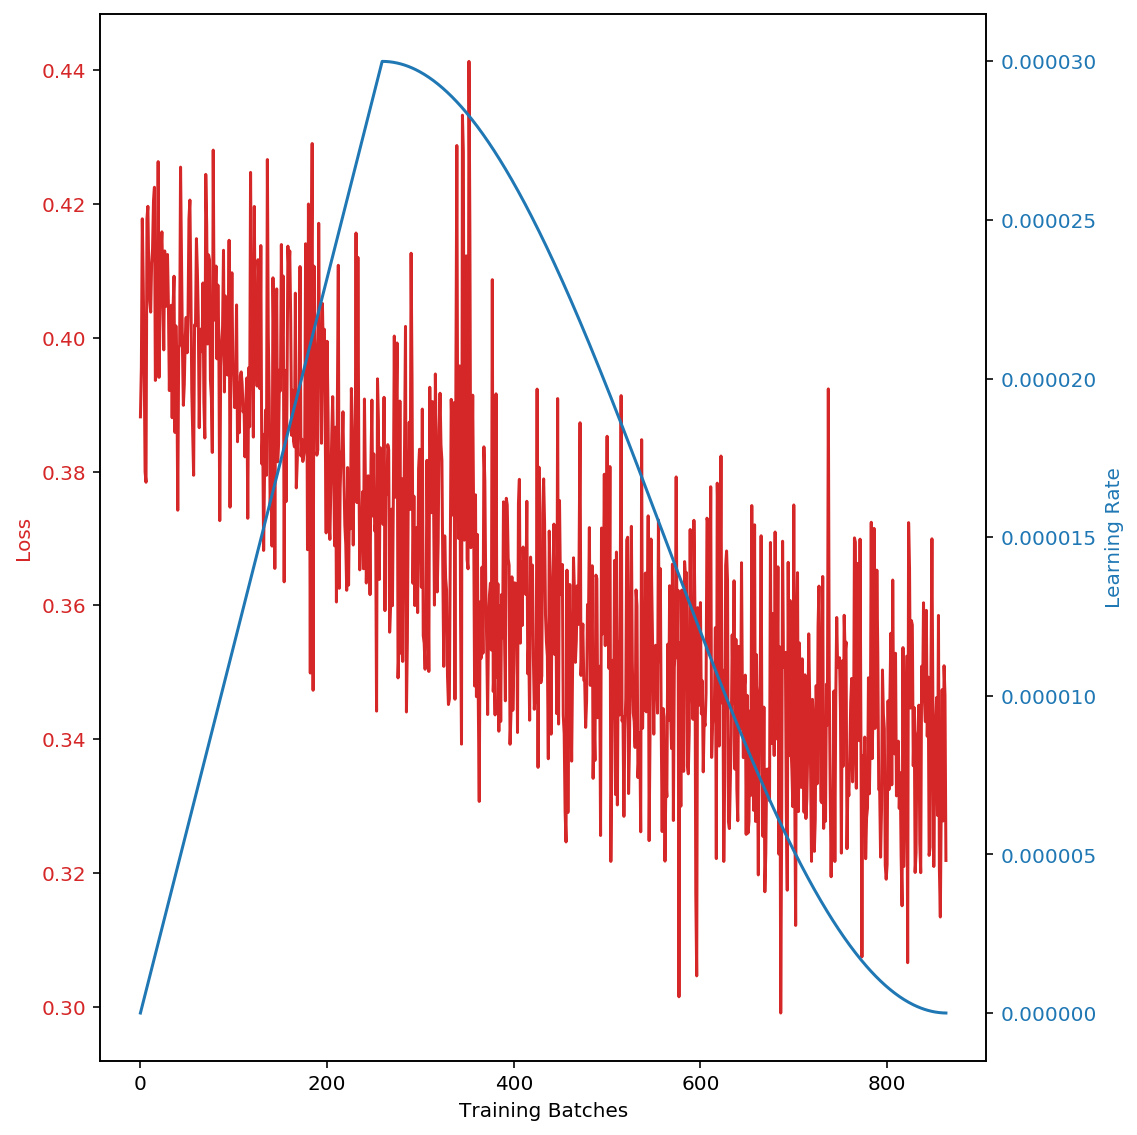

,id,proba,label
281,46197,0.417,0
17,38045,0.566,1
194,35687,0.442,0
350,65148,0.548,1
691,10462,0.597,1


In [13]:
epochs = 24
submission, text_model = train_and_predict((model, optimizer), data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 34, 42, 46],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
